# Lending Club Dataset Exploration 3 - more fine-tune to Exploration 2

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing, pipeline, metrics, model_selection

pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100
sns.set_style("white")
%matplotlib inline

__Datasets questions:__

1. Target variale distribution
2. Numerical features (float64 and int64)
3. Object features and possible convert to numerical features
4. Feature correlation
5. Missing value handling


In [2]:
full_clean_df = pd.read_csv("full_clean_data.csv")

In [3]:
# set id is the index
full_clean_df.set_index('id', inplace=True)

In [4]:
full_clean_df.head(5)

loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  \
id                                                                      
1077501       5000         5000           4975.0   36 months   10.65%   
1077430       2500         2500           2500.0   60 months   15.27%   
1077175       2400         2400           2400.0   36 months   15.96%   
1076863      10000        10000          10000.0   36 months   13.49%   
1075358       3000         3000           3000.0   60 months   12.69%   

         installment grade sub_grade                 emp_title emp_length  \
id                                                                          
1077501       162.87     B        B2                       NaN  10+ years   
1077430        59.83     C        C4                     Ryder   < 1 year   
1077175        84.33     C        C5                       NaN  10+ years   
1076863       339.31     C        C1       AIR RESOURCES BOARD  10+ years   
1075358        67.79     B        B5  University Medical Group     1 year   

        home_ownership  annual_inc verification_status   issue_d  loan_status  \
id                                                                              
1077501           RENT     24000.0            Verified  Dec-2011   Fully Paid   
1077430           RENT     30000.0     Source Verified  Dec-2011  Charged Off   
1077175           RENT     12252.0        Not Verified  Dec-2011   Fully Paid   
1076863           RENT     49200.0     Source Verified  Dec-2011   Fully Paid   
1075358           RENT     80000.0     Source Verified  Dec-2011   Fully Paid   

        pymnt_plan  \
id                   
1077501          n   
1077430          n   
1077175          n   
1076863          n   
1075358          n   

                                                                      url  \
id                                                                          
1077501  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501   
1077430  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430   
1077175  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175   
1076863  https://lendingclub.com/browse/loanDetail.action?loan_id=1076863   
1075358  https://lendingclub.com/browse/loanDetail.action?loan_id=1075358   

                                                                                                        desc  \
id                                                                                                             
1077501                         Borrower added on 12/22/11 > I need to upgrade my business technologies.<br>   
1077430    Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking a...   
1077175                                                                                                  NaN   
1076863    Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & ...   
1075358    Borrower added on 12/21/11 > I plan on combining three large interest bills together and freei...   

                purpose                 title zip_code addr_state    dti  \
id                                                                         
1077501     credit_card              Computer    860xx         AZ  27.65   
1077430             car                  bike    309xx         GA   1.00   
1077175  small_business  real estate business    606xx         IL   8.72   
1076863           other              personel    917xx         CA  20.00   
1075358           other              Personal    972xx         OR  17.94   

         delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
id                                                                       
1077501            0         Jan-1985             735              739   
1077430            0         Apr-1999             740              744   
1077175            0         Nov-2001             735              739   
107686

## Target variable: loan_status

Sample size of label "Charge Off" has ~ 20% size of "Fully Paid". Normally, label with smaller group has larger impact on the evaluation. As the smaller group, "charge off" has enormous impact on the risk of loan business.


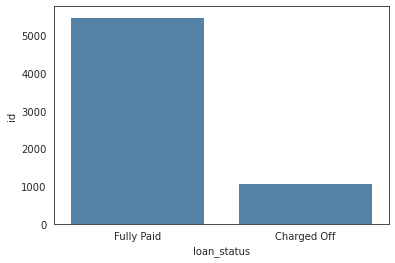

In [5]:
# Target variable loan_status
sns.barplot(x='loan_status', y='id', data=full_clean_df.reset_index(),
            label='Loan data', estimator=np.ma.count, color='steelblue')

"charge off" prediction can be seen as a classification problem, so it's convenient to transform the data type of loan_status to nuemrical type

In [6]:
# Numerical type conversion
full_clean_df['loan_status'] = full_clean_df['loan_status'].apply(lambda x: 1 if x=='Charged Off' else 0) 

In [7]:
sum(full_clean_df['loan_status'])/len(full_clean_df['loan_status'])

0.16580625569389615

__group features by data type__


In [8]:
# numeric variables
num_cols = list(full_clean_df.select_dtypes('number').columns)
num_cols.remove('loan_status')

# object variables
obj_cols = list(full_clean_df.select_dtypes('object').columns)


# datetime variables
dt_cols = list(full_clean_df.select_dtypes('datetime').columns)

# index column
id_col = 'id'

# target column
target_col = 'loan_status'

print("Numeric variables: \n", num_cols)
print("Object variables: \n", obj_cols)
print("Datetime variables: \n", dt_cols)
print("Index variable: \n", id_col)
print("Target variable: \n", target_col)

Numeric variables: 
 ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_

In [9]:
# create new df for visulization
import copy
vis_train_df = copy.copy(full_clean_df)

__FICO scores: common features to evaluate  credit info__

The lower boundary range the borrower's FICO at loan origination belongs to.

The upper boundary range the borrower's FICO at loan origination belongs to.


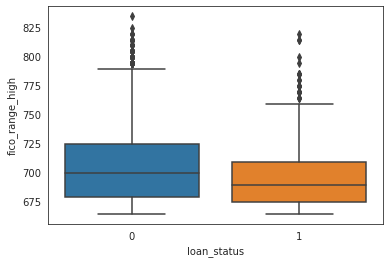

In [10]:
# FICO scores: fico_range_high
sns.boxplot(x='loan_status', y='fico_range_high', data=vis_train_df)

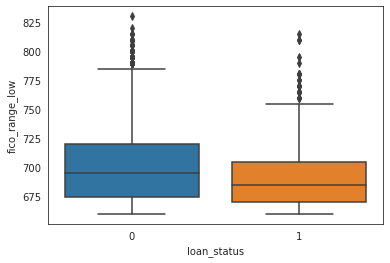

In [11]:
# FICO scores: fico_range_low
sns.boxplot(x='loan_status', y='fico_range_low', data=vis_train_df)

label 1, "charge off", has lower fico score range in general

__The upper boundary range the borrower last FICO pulled belongs__


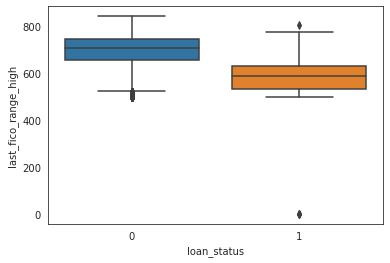

In [12]:
# last_fico_range_high
sns.boxplot(x='loan_status', y='last_fico_range_high', data=vis_train_df)

It could be used for predict

__The lower boundary range the borrower last FICO pulled belongs__

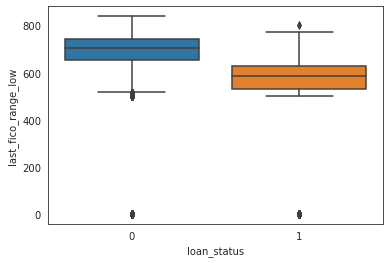

In [13]:
# last_fico_range_low
sns.boxplot(x='loan_status', y='last_fico_range_low', data=vis_train_df)

This feature could be used for prediction.

__The number of accounts on which the borrower is now delinquent.__


nearly all of entries in this column are 0. It's hard to use this feature to predict.

In [14]:
vis_train_df['acc_now_delinq'].value_counts()

0    6578
1       7
2       1
Name: acc_now_delinq, dtype: int64

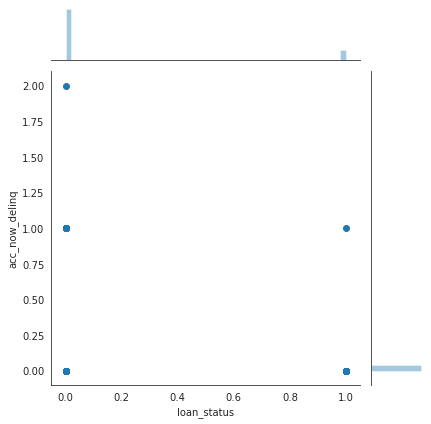

In [15]:
sns.jointplot(x='loan_status', y='acc_now_delinq', data=vis_train_df)

__Number of charge-offs within 12 months__

In [16]:
# chargeoff_within_12_mths
vis_train_df['acc_now_delinq'].value_counts()

0    6578
1       7
2       1
Name: acc_now_delinq, dtype: int64

Hard to use this feature to predict

__The past-due amount owed for the accounts on which the borrower is now delinquent.__

In [17]:
# chargeoff_within_12_mths
vis_train_df['delinq_amnt'].value_counts()

0       6582
1033       1
353        1
321        1
456        1
Name: delinq_amnt, dtype: int64

 Hard to use feature to predict

__Number of public record bankruptcies__

In [18]:
# pub_rec_bankruptcies
vis_train_df['pub_rec_bankruptcies'].value_counts()


0    6140
1     434
2      10
3       1
4       1
Name: pub_rec_bankruptcies, dtype: int64

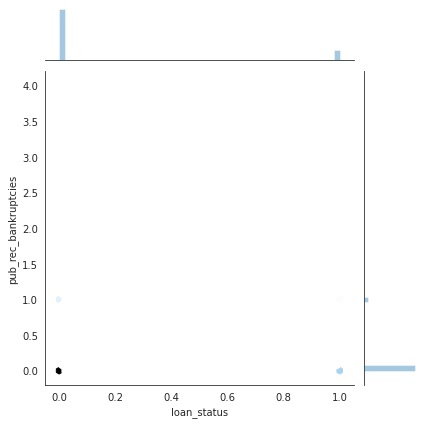

In [19]:
sns.jointplot(x='loan_status', y='pub_rec_bankruptcies', data=vis_train_df,kind="hex")

Hard to use this feature to predict too

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


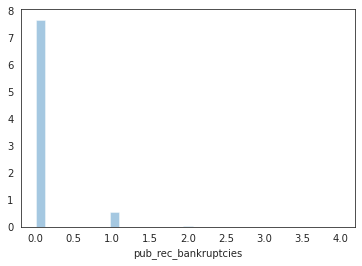

In [22]:
status_1 = vis_train_df[vis_train_df['loan_status']==1].pub_rec_bankruptcies
sns.distplot(status_1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


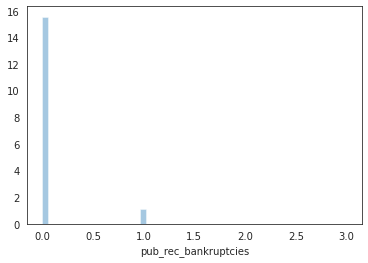

In [23]:
status_0 = vis_train_df[vis_train_df['loan_status']==0].pub_rec_bankruptcies
sns.distplot(status_0)

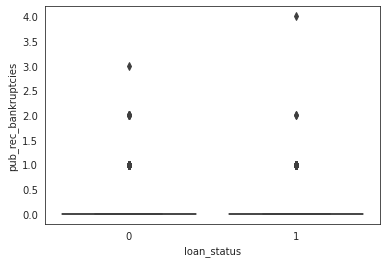

In [42]:
sns.boxplot(x='loan_status', y='pub_rec_bankruptcies', data=vis_train_df)

__Number of tax liens__

In [24]:
# tax_liens
vis_train_df['tax_liens'].value_counts()

0    6499
1      54
2      21
3       8
4       3
8       1
Name: tax_liens, dtype: int64

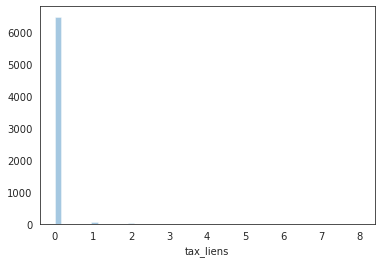

In [39]:
sns.distplot(vis_train_df['tax_liens'],kde=False)

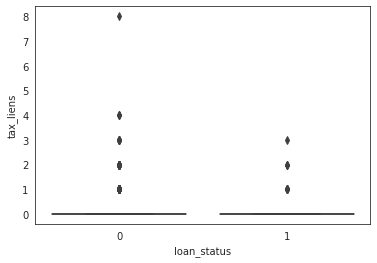

In [41]:
sns.boxplot(x='loan_status', y='tax_liens', data=vis_train_df)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


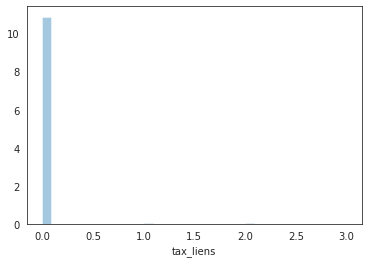

In [29]:
status_tax_liens_1 = vis_train_df[vis_train_df['loan_status']==1].tax_liens
sns.distplot(status_tax_liens_1)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


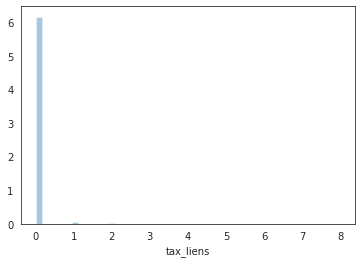

In [30]:
status_tax_liens_0 = vis_train_df[vis_train_df['loan_status']==0].tax_liens
sns.distplot(status_tax_liens_0)

Hard to predict use this feature too

__The total number of credit lines currently in the borrower's credit file__

In [43]:
# total_acc
vis_train_df['total_acc'].value_counts()


17    264
18    260
15    260
21    240
24    239
     ... 
56      7
62      5
58      3
65      1
79      1
Name: total_acc, Length: 63, dtype: int64

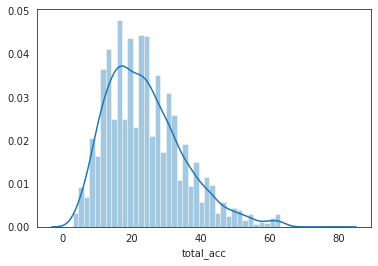

In [44]:
sns.distplot(vis_train_df.total_acc)

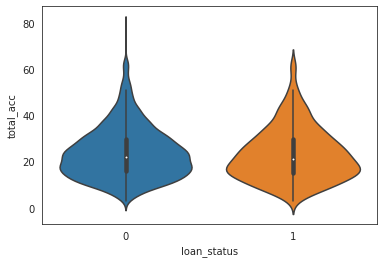

In [45]:
sns.violinplot(x = 'loan_status', y ='total_acc', data = vis_train_df)

This feature could be used for prediction

__The number of open credit lines in the borrower's credit file__

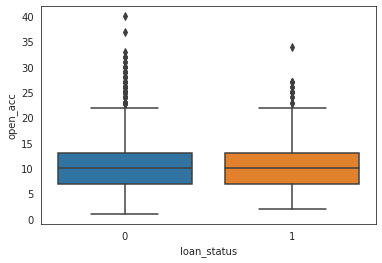

In [46]:
# open_acc
sns.boxplot(x = 'loan_status', y ='open_acc', data = vis_train_df)

This feature could be used for prediction

__The listed amount of the loan applied for by the borrower__

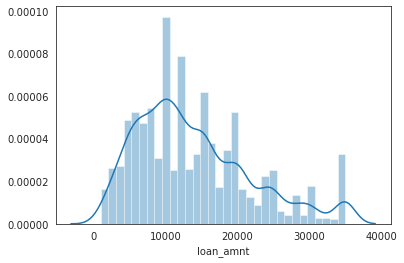

In [47]:
# loan_amnt
sns.distplot(vis_train_df.loan_amnt)

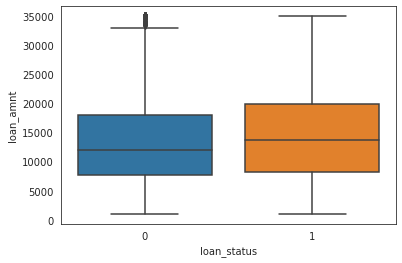

In [48]:
sns.boxplot(x = 'loan_status', y ='loan_amnt', data = vis_train_df)

This feature could be used for prediction

__The total amount committed to that loan at that point in time.__

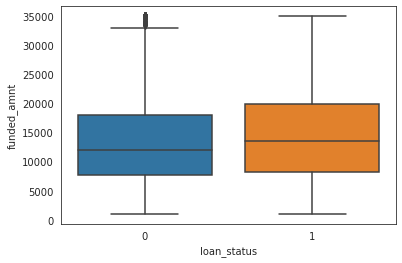

In [49]:
# funded_amnt
sns.boxplot(x = 'loan_status', y ='funded_amnt', data = vis_train_df)

This feature could be used for prediction

__The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years__

In [50]:
# # delinq_2yrs
vis_train_df['delinq_2yrs'].value_counts()


0    5667
1     662
2     161
3      61
4      20
5       6
6       4
7       3
9       1
8       1
Name: delinq_2yrs, dtype: int64

Possible to use for prediction.

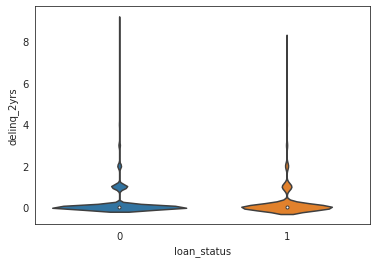

In [52]:
sns.violinplot(x='loan_status', y='delinq_2yrs', data=vis_train_df)

__The number of inquiries in past 6 months (excluding auto and mortgage inquiries)__

In [53]:
# inq_last_6mths
vis_train_df['inq_last_6mths'].value_counts()


0    3062
1    2022
2     983
3     424
4      67
5      21
6       4
7       2
8       1
Name: inq_last_6mths, dtype: int64

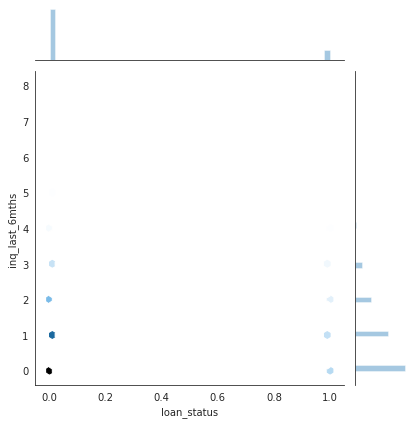

In [54]:
sns.jointplot(x='loan_status', y='inq_last_6mths', data=vis_train_df,kind="hex")

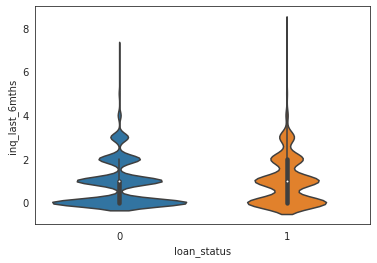

In [55]:
sns.violinplot(x='loan_status', y='inq_last_6mths', data=vis_train_df)

Could be to use for prediction.

__Number of derogatory public records__

In [56]:
# pub_rec
vis_train_df['pub_rec'].value_counts()


0    6019
1     502
2      40
3      17
4       5
6       1
9       1
5       1
Name: pub_rec, dtype: int64

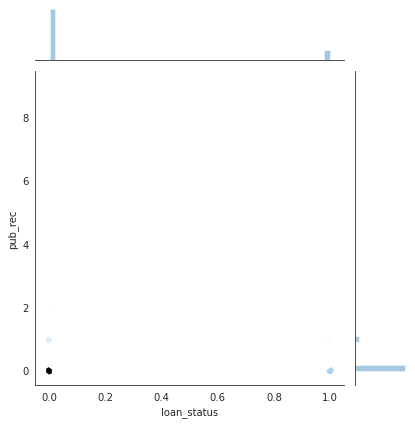

In [57]:
sns.jointplot(x='loan_status', y='pub_rec', data=vis_train_df,kind="hex")

Possible to use for prediction

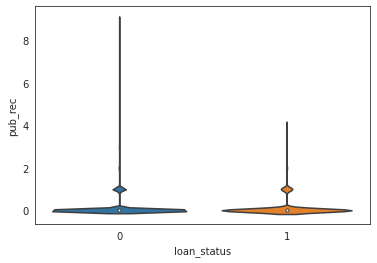

In [58]:
sns.violinplot(x='loan_status', y='pub_rec', data=vis_train_df)

__Total credit revolving balance__

In [59]:
# revol_bal
vis_train_df['revol_bal'].value_counts()


0        38
10249     4
11926     4
6565      4
9881      4
         ..
3215      1
17045     1
15505     1
3219      1
10193     1
Name: revol_bal, Length: 5846, dtype: int64

In [60]:
print(vis_train_df['revol_bal'].max())
print(vis_train_df['revol_bal'].min())

236666
0


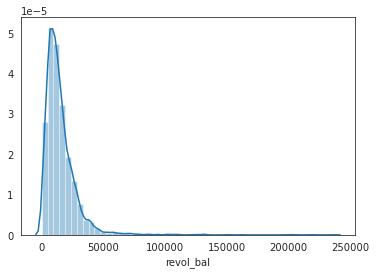

In [61]:
sns.distplot(vis_train_df.revol_bal)

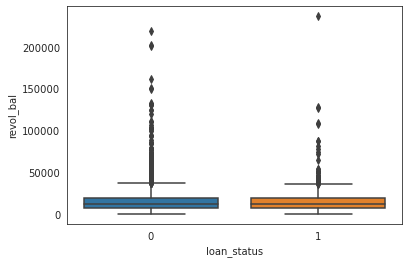

In [62]:
sns.boxplot(x = 'loan_status', y ='revol_bal', data = vis_train_df)

Possible to use for prediction.

__publicly available policy_code=1 new products not publicly available policy_code=2__

In [63]:
# policy_code
vis_train_df['policy_code'].value_counts()

1    6586
Name: policy_code, dtype: int64

Couldn't be used for prediction.

__Number of collections in 12 months excluding medical collection__


In [64]:
# collections_12_mths_ex_med
vis_train_df['collections_12_mths_ex_med'].value_counts()

0    6562
1      23
2       1
Name: collections_12_mths_ex_med, dtype: int64

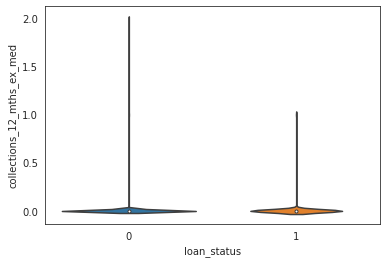

In [65]:
sns.violinplot(x='loan_status', y='collections_12_mths_ex_med', data=vis_train_df)

Could not be use.

__int64 type feature summary__
features could be used for prediction model are:

loan_amnt, funded_amnt,delinq_2yrs, fico_range_low, fico_range_high, \
inq_last_6mths, open_acc, pub_rec, revol_bal, total_acc, last_fico_range_high, last_fico_range_low



In [67]:
selected_int_features = ["loan_amnt", "funded_amnt,delinq_2yrs", "fico_range_low", "fico_range_high", \
"inq_last_6mths", "open_acc", "pub_rec", "revol_bal", "total_acc", "last_fico_range_high", "last_fico_range_low"]

In [68]:
len(selected_int_features)

11

## float64 type features


__Features have 0 Null value__


In [69]:
no_null_float_features = ['funded_amnt_inv', 'installment', 'annual_inc', 'dti', 'out_prncp', \
                    'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', \
                    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt']

In [71]:
len(no_null_float_features)

14

In [72]:
vis_train_df[no_null_float_features].describe()

funded_amnt_inv  installment      annual_inc          dti  out_prncp  \
count      6586.000000  6586.000000     6586.000000  6586.000000     6586.0   
mean      13711.931421   414.684581    70690.569182    15.926965        0.0   
std        7914.950977   232.930244    44588.806908     7.025740        0.0   
min        1000.000000    32.230000     9600.000000     0.000000        0.0   
25%        7950.000000   249.080000    45000.000000    10.680000        0.0   
50%       12000.000000   366.860000    60000.000000    15.840000        0.0   
75%       18000.000000   533.402500    85000.000000    20.880000        0.0   
max       35000.000000  1406.450000  1000000.000000    34.930000        0.0   

       out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
count         6586.0   6586.000000      6586.000000      6586.000000   
mean             0.0  15489.683547     15453.638069     12182.292795   
std              0.0  10306.316858     10271.092614      8011.445053   
min              0.0      0.000000         0.000000         0.000000   
25%              0.0   7846.645209      7839.910000      6000.000000   
50%              0.0  13086.192582     13043.310000     10000.000000   
75%              0.0  20744.544817     20672.087500     16000.000000   
max              0.0  59636.769736     59636.770000     35000.000000   

       total_rec_int  total_rec_late_fee    recoveries  \
count    6586.000000         6586.000000   6586.000000   
mean     3119.865742            1.092635    186.432378   
std      3257.562410            9.939914    901.585083   
min         0.000000            0.000000      0.000000   
25%      1014.820000            0.000000      0.000000   
50%      2015.515000            0.000000      0.000000   
75%      4002.210000            0.000000      0.000000   
max     24636.770000          536.760000  27009.470000   

       collection_recovery_fee  last_pymnt_amnt  
count              6586.000000      6586.000000  
mean                 23.004697      3985.130575  
std                 141.524390      5654.865858  
min                   0.000000         0.000000  
25%                   0.000000       341.640000  
50%                   0.000000       917.515000  
75%                   0.000000      5913.865000  
max                4772.525700     35436.920000

features that not used (0 on all quarters): __out_prncp, out_prncp_inv, total_rec_late_fee, recoveries, collection_recovery_fee__

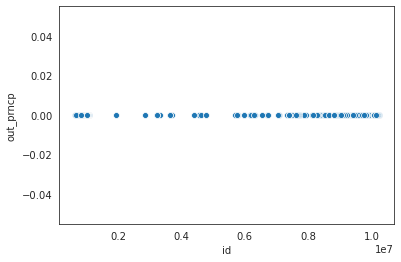

In [73]:
# out_prncp
sns.scatterplot(x="id", y="out_prncp", data=vis_train_df.reset_index())

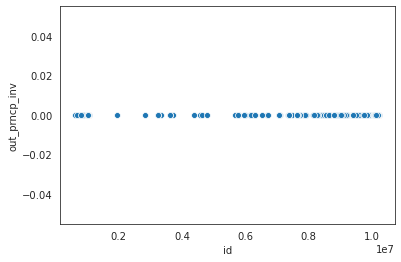

In [74]:
# out_prncp_inv
sns.scatterplot(x="id", y="out_prncp_inv", data=vis_train_df.reset_index())

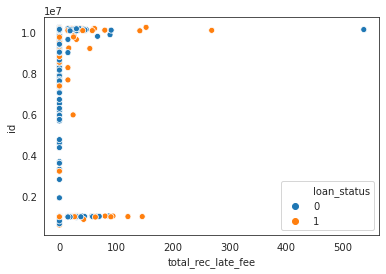

In [78]:
# total_rec_late_fee
sns.scatterplot(x="total_rec_late_fee", y="id", data=vis_train_df.reset_index(),hue='loan_status')

It looks like id num near the bottom and top has significant higher total_rec_late_fee 

__post charge off gross recovery__

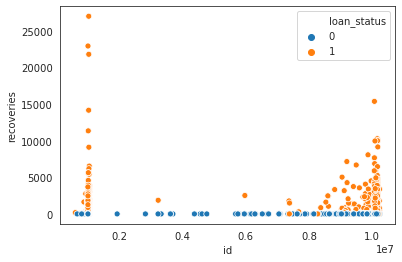

In [80]:
# recoveries
sns.scatterplot(x="id", y="recoveries", data=vis_train_df.reset_index(),hue='loan_status')

From the feature desc, it looks like a data leak feature. As "total_rec_late_fee" above,  It looks like id num near the bottom and top has significant higher total_rec_late_fee 

__post charge off collection fee__

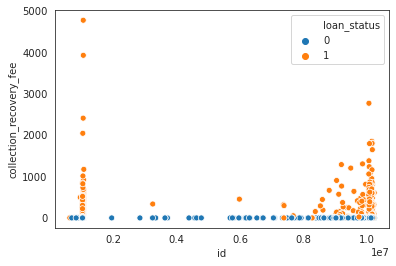

In [81]:
# collection_recovery_fee
sns.scatterplot(x="id", y="collection_recovery_fee", data=vis_train_df.reset_index(),hue='loan_status')

From the feature desc, it looks like a data leak feature.

In [83]:
no_null_float_features_kept = list( set(no_null_float_features).difference(set(['out_prncp', 'out_prncp_inv', \
                                                                            'total_rec_late_fee', 'recoveries', 'collection_recovery_fee'])))

__Those are orignal not-null values feature that finally kept__

In [84]:
no_null_float_features_kept

['total_pymnt_inv',
 'total_rec_prncp',
 'last_pymnt_amnt',
 'funded_amnt_inv',
 'dti',
 'total_pymnt',
 'installment',
 'annual_inc',
 'total_rec_int']

In [85]:
len(no_null_float_features_kept)

9

Show two features interactions for those features:

- "total_pymnt_inv" and "total_pymnt" almost linear related
- the "charge off" label in "last_pymnt_amnt" clearly shown as the vertical line


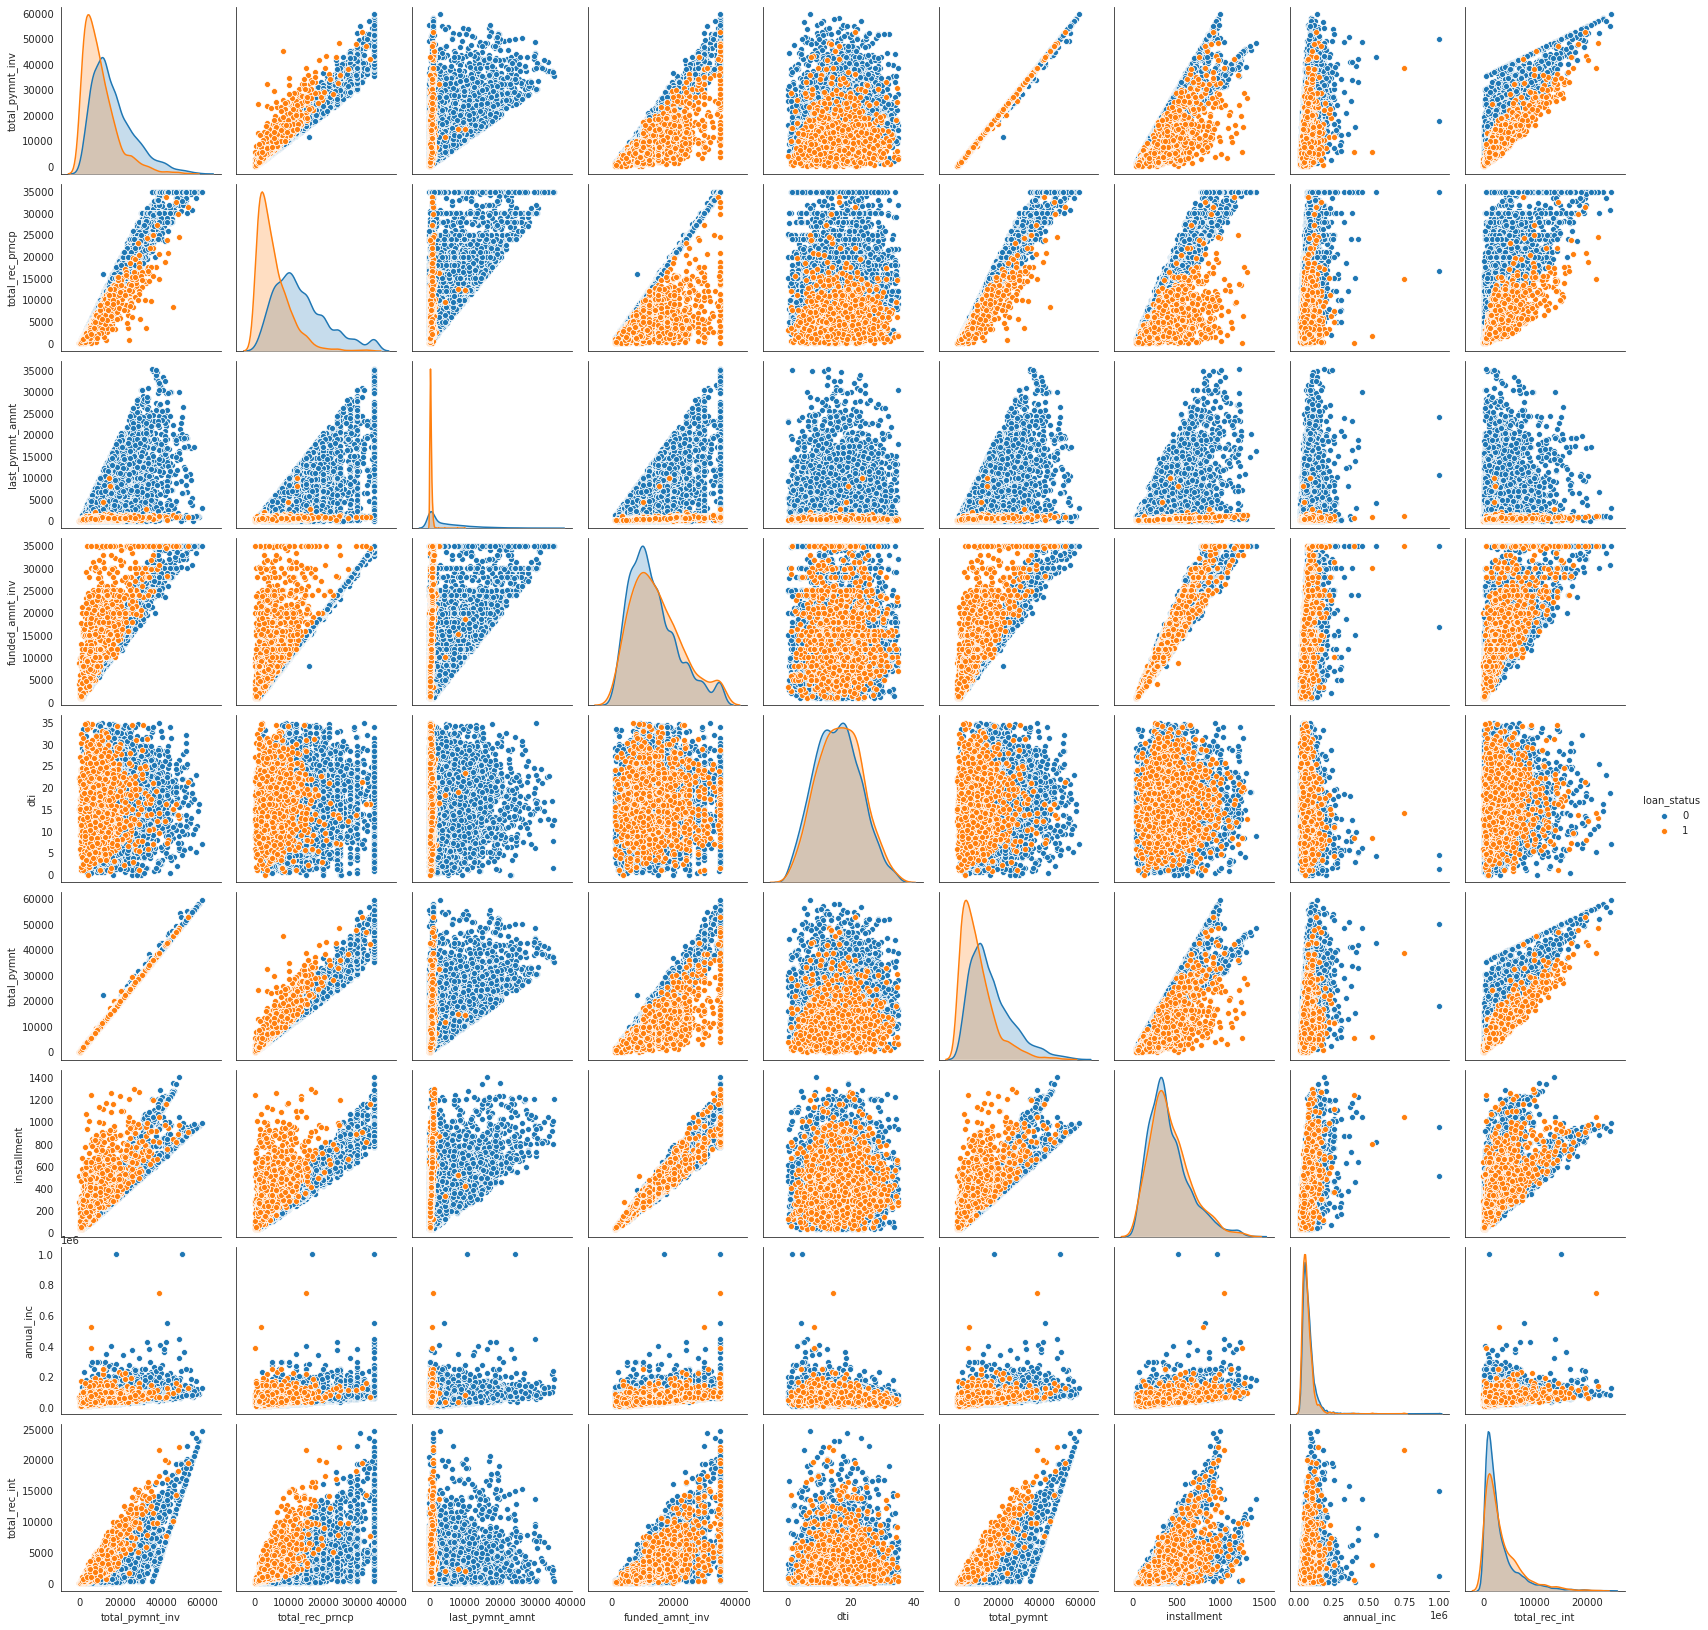

In [86]:
sns.pairplot(vis_train_df, vars=no_null_float_features_kept, hue='loan_status')

__Float type features that has missing values__

In [87]:
float_list = list(vis_train_df.select_dtypes('float64').columns)

In [88]:
float_hasNull_list = list(set(float_list).difference(set(no_null_float_features)))

In [100]:
float_hasNull_list

['mths_since_last_major_derog',
 'mo_sin_rcnt_tl',
 'bc_open_to_buy',
 'pct_tl_nvr_dlq',
 'num_tl_30dpd',
 'num_tl_op_past_12m',
 'mo_sin_old_rev_tl_op',
 'avg_cur_bal',
 'mo_sin_old_il_acct',
 'mo_sin_rcnt_rev_tl_op',
 'num_actv_rev_tl',
 'num_rev_tl_bal_gt_0',
 'tot_hi_cred_lim',
 'bc_util',
 'num_op_rev_tl',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'num_sats',
 'total_il_high_credit_limit',
 'num_rev_accts',
 'total_bal_ex_mort',
 'acc_open_past_24mths',
 'mths_since_recent_bc',
 'percent_bc_gt_75',
 'num_accts_ever_120_pd',
 'num_bc_sats',
 'total_rev_hi_lim',
 'num_bc_tl',
 'total_bc_limit',
 'mort_acc',
 'num_tl_90g_dpd_24m',
 'mths_since_recent_inq',
 'mths_since_last_delinq',
 'num_il_tl',
 'num_tl_120dpd_2m',
 'tot_cur_bal',
 'num_actv_bc_tl',
 'tot_coll_amt']

In [89]:
len(float_hasNull_list)

38

In [90]:
vis_train_df[float_hasNull_list].describe()

mths_since_last_major_derog  mo_sin_rcnt_tl  bc_open_to_buy  \
count                   767.000000     3354.000000     3326.000000   
mean                     42.358540        7.659511     7863.983764   
std                      20.424043        8.600300    12532.619126   
min                       1.000000        0.000000        0.000000   
25%                      26.000000        3.000000     1173.750000   
50%                      42.000000        5.000000     3399.000000   
75%                      59.000000       10.000000     8911.750000   
max                     110.000000      102.000000   162694.000000   

       pct_tl_nvr_dlq  num_tl_30dpd  num_tl_op_past_12m  mo_sin_old_rev_tl_op  \
count     3354.000000   3354.000000         3354.000000           3354.000000   
mean        95.139952      0.001491            1.914729            176.829756   
std          7.461493      0.038587            1.475681             87.313986   
min         33.300000      0.000000            0.000000             13.000000   
25%         92.900000      0.000000            1.000000            114.000000   
50%        100.000000      0.000000            2.000000            161.000000   
75%        100.000000      0.000000            3.000000            225.000000   
max        100.000000      1.000000           15.000000            557.000000   

         avg_cur_bal  mo_sin_old_il_acct  mo_sin_rcnt_rev_tl_op  \
count    3354.000000         3243.000000            3354.000000   
mean    13383.187835          127.063830              12.830352   
std     15359.531725           51.781227              15.660567   
min       256.000000            0.000000               0.000000   
25%      3073.000000           97.500000               3.000000   
50%      7615.500000          129.000000               8.000000   
75%     18586.250000          153.000000              16.000000   
max    161880.000000          384.000000             221.000000   

       num_actv_rev_tl  num_rev_tl_bal_gt_0  tot_hi_cred_lim      bc_util  \
count      3354.000000          3354.000000     3.354000e+03  3325.000000   
mean          5.827967             5.820215     1.690968e+05    66.794526   
std           2.920241             2.926100     1.658496e+05    24.813450   
min           0.000000             0.000000     5.000000e+02     0.000000   
25%           4.000000             4.000000     4.567975e+04    50.100000   
50%           5.000000             5.000000     1.112035e+05    71.100000   
75%           7.000000             7.000000     2.500922e+05    87.800000   
max          24.000000            24.000000     1.632423e+06   109.700000   

       num_op_rev_tl  mths_since_recent_bc_dlq  \
count    3354.000000                822.000000   
mean        8.136255                 39.714112   
std         3.868042                 21.988642   
min         1.000000                  0.000000   
25%         5.000000                 21.000000   
50%         8.000000                 39.000000   
75%        10.000000                 58.000000   
max        29.000000                 84.000000   

       mths_since_recent_revol_delinq     num_sats  \
count                     1120.000000  3354.000000   
mean                        34.693750    11.492546   
std                         21.535389     4.735797   
min                          0.000000     1.000000   
25%                         16.000000     8.000000   
50%                         32.000000    11.000000   
75%                         49.250000    14.000000   
max                         84.000000    40.000000   

       total_il_high_credit_limit  num_rev_accts  total_bal_ex_mort  \
count                 3354.000000    3354.000000        3354.000000   
mean                 39603.464222      15.163983       47276.697376   
std                  38632.723687       7.639230       40470.950484   
min                      0.000000       2.000000         307.000000   
25%                  13600.750000      10.000000       

**suspceted** : 

num_tl_30dpd,
num_tl_120dpd_2m, 
num_tl_90g_dpd_24m
tot_coll_amt, 
num_accts_ever_120_pd, 

**look like Int or Categorical:**

mort_acc,
num_actv_rev_tl,
num_op_rev_tl,
nths_since_recent_bc,
num_il_tl,
mo_sin_rcnt_tl,
mths_since_last_delinq,
num_rev_accts,
mths_since_recent_inq,
num_rev_tl_bal_gt_0,
mths_since_last_major_derog,
num_bc_tl,
num_tl_op_past_12m,







__suspected__

num_tl_30dpd,
num_tl_120dpd_2m, 
num_tl_90g_dpd_24m
tot_coll_amt, 
num_accts_ever_120_pd, 


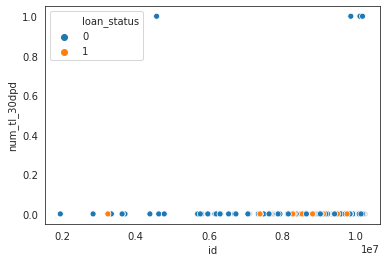

In [91]:
# num_tl_30dpd, Number of accounts currently 30 days past due (updated in past 2 months)
sns.scatterplot(x="id", y="num_tl_30dpd", data=vis_train_df.reset_index(),hue='loan_status')

Nearly all of them are '0's. Not useful

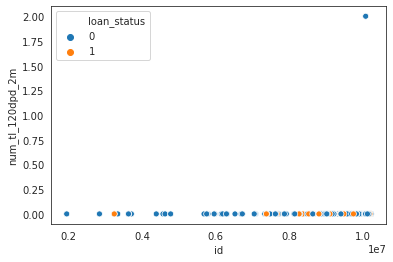

In [92]:
# num_tl_120dpd_2m, Number of accounts currently 120 days past due (updated in past 2 months)
sns.scatterplot(x="id", y="num_tl_120dpd_2m", data=vis_train_df.reset_index(),hue='loan_status')

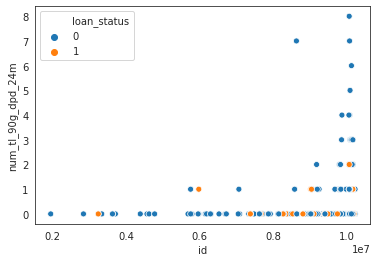

In [95]:
# num_tl_90g_dpd_24m, Number of accounts 90 or more days past due in last 24 months
sns.scatterplot(x="id", y="num_tl_90g_dpd_24m", data=vis_train_df.reset_index(),hue='loan_status')

Looks the variance of this feature increased along with the id num

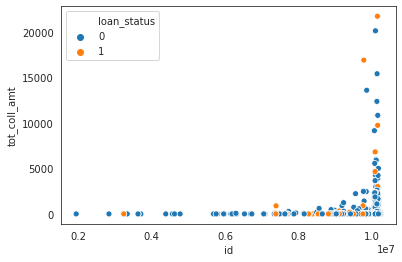

In [94]:
# tot_coll_amt, Total collection amounts ever owed
sns.scatterplot(x="id", y="tot_coll_amt", data=vis_train_df.reset_index(),hue='loan_status')

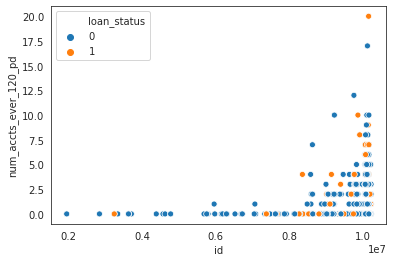

In [96]:
# num_accts_ever_120_pd,Number of accounts ever 120 or more days past due
sns.scatterplot(x="id", y="num_accts_ever_120_pd", data=vis_train_df.reset_index(),hue='loan_status')

The "num_tl_90g_dpd_24m", "tot_coll_amt", "num_accts_ever_120_pd" and "num_accts_ever_120_pd" variance incrased with id num. Those  features more or less related with time. The "id" num may related to time too.

**look like Int or Categorical:**

mort_acc,
num_actv_rev_tl,
num_op_rev_tl,
nths_since_recent_bc,
num_il_tl,
mo_sin_rcnt_tl,
mths_since_last_delinq,
num_rev_accts,
mths_since_recent_inq,
num_rev_tl_bal_gt_0,
mths_since_last_major_derog,
num_bc_tl,
num_tl_op_past_12m,


In [98]:
# mort_acc, Number of mortgage accounts.
vis_train_df['mort_acc'].value_counts()

0.0     1333
1.0      536
2.0      437
3.0      376
4.0      270
5.0      159
6.0      109
7.0       66
8.0       30
9.0       19
10.0       6
11.0       5
12.0       3
15.0       2
14.0       2
13.0       1
Name: mort_acc, dtype: int64

In [99]:
# num_actv_rev_tl
vis_train_df['num_actv_rev_tl'].value_counts()

5.0     550
4.0     495
6.0     463
3.0     409
7.0     326
8.0     290
2.0     230
9.0     167
10.0    118
11.0     87
1.0      65
12.0     46
13.0     38
15.0     19
14.0     15
16.0     13
0.0       7
17.0      7
19.0      4
18.0      2
20.0      1
24.0      1
21.0      1
Name: num_actv_rev_tl, dtype: int64

__Missing values impuptation__

There are several schemes for imputation of missing values as introduced in [sklearn](https://scikitlearn.org/stable/modules/impute.html)

At this moment, since the tree model will be applied, just use -999.9 to replace the Nulls that the tree model should handle it well.


In [ ]:
vis_train_df[float_hasNull_list] = vis_train_df[float_hasNull_list].fillna(-999.9)

In [ ]:
vis_train_df[float_hasNull_list].describe()

## Object datatype features

Object datatype could be string, categorical, int, and float

__The number of payments on the loan. Values are in months and can be either 36 or 60__

In [101]:
# term
vis_train_df['term'].value_counts()

 36 months    4720
 60 months    1866
Name: term, dtype: int64

This faeture could convert to numerical by label encoding

__Interest Rate on the loan__

In [102]:
sum(vis_train_df['int_rate'].isnull())

0

In [103]:
# int_rate
vis_train_df['int_rate'].value_counts()

  7.90%    332
  8.90%    308
 11.71%    257
 11.99%    229
 12.69%    216
          ... 
 25.57%      4
 22.74%      3
 24.11%      2
 26.06%      1
 25.99%      1
Name: int_rate, Length: 66, dtype: int64

In [104]:
vis_train_df['int_rate'].head()

id
1077501     10.65%
1077430     15.27%
1077175     15.96%
1076863     13.49%
1075358     12.69%
Name: int_rate, dtype: object

In [105]:
# convert to float with regex 
# "\d+\.\d+"
vis_train_df['int_rate'] = vis_train_df['int_rate'].str.extract(r"(\d+\.\d+)").astype('float')

In [108]:
vis_train_df['int_rate'].mean()

13.713442150015345

This fature convert to float type

__LC assigned loan grade__

Loan grade and subgrade has different trench, so it's ordinal as listed in [LC website](https://www.lendingclub.com/foliofn/rateDetail.action)

In [109]:
# grade
vis_train_df['grade'].value_counts()

B    2036
C    1651
A    1190
D     988
E     507
F     175
G      39
Name: grade, dtype: int64

Label Encoding, A->0, B->1, C->2, D->3,E->4, F->5, G->6

__LC assigned loan subgrade__

Loan subgrade has different trench, so it's ordinal as listed in [LC website](https://www.lendingclub.com/foliofn/rateDetail.action)

In [110]:
# sub_grade
vis_train_df['sub_grade'].value_counts()

B3    487
B5    433
B4    421
C1    415
C2    392
B2    357
B1    338
A4    332
C3    308
A5    308
C4    280
C5    256
D2    227
D3    226
A3    219
D1    215
A2    177
D4    172
A1    154
D5    148
E1    131
E2    129
E3     87
E5     81
E4     79
F1     65
F2     35
F3     31
F4     30
F5     14
G3     11
G1     10
G2      9
G4      6
G5      3
Name: sub_grade, dtype: int64

Label Encoding, A1-A5: 0-4, B1-B5: 5-9, C1-C5: 10-14, D1-D5: 15-19, E1-E5: 20-24, F1-F5: 25-29, G1-G5: 30-34


if have extra time, could try mean_coding

In [111]:
def sub_grade_encode(val):
    if val[0] == 'A':
        return int(val[1]) - 1
    if val[0] == 'B':
        return int(val[1]) + 4
    if val[0] == 'C':
        return int(val[1]) + 9
    if val[0] == 'D':
        return int(val[1]) + 14
    if val[0] == 'E':
        return int(val[1]) + 19
    if val[0] == 'F':
        return int(val[1]) + 24
    else: # 'G'
        return int(val[1]) + 29

In [114]:
vis_train_df['sub_grade'].head()

id
1077501    B2
1077430    C4
1077175    C5
1076863    C1
1075358    B5
Name: sub_grade, dtype: object

In [113]:
vis_train_df['sub_grade'].apply(sub_grade_encode)

id
1077501      6
1077430     13
1077175     14
1076863     10
1075358      9
            ..
10085132     0
8999284      3
9027724      5
10175044     6
10135034    14
Name: sub_grade, Length: 6586, dtype: int64

__The home ownership status provided by the borrower during registration?__

In [115]:
# home_ownership
vis_train_df['home_ownership'].value_counts()

RENT        3065
MORTGAGE    2998
OWN          523
Name: home_ownership, dtype: int64

Label Encoding

__Indicates if income was verified by LC, not verified, or if the income source was verified__

In [116]:
# verification_status
vis_train_df['verification_status'].value_counts()

Verified           2497
Not Verified       2088
Source Verified    2001
Name: verification_status, dtype: int64

Label Encoding

__The month which the loan was funded__

In [117]:
# issue_d
vis_train_df['issue_d'].value_counts()

Dec-2013    3354
Dec-2011    2266
Nov-2011     966
Name: issue_d, dtype: int64

In [121]:
pd.to_datetime(vis_train_df['issue_d'], format="%b-%Y").dt.to_period('M')

id
1077501     2011-12
1077430     2011-12
1077175     2011-12
1076863     2011-12
1075358     2011-12
             ...   
10085132    2013-12
8999284     2013-12
9027724     2013-12
10175044    2013-12
10135034    2013-12
Name: issue_d, Length: 6586, dtype: period[M]

datatime encoding: into year-month, month, and year

__Indicates if a payment plan has been put in place for the loan__

In [122]:
# pymnt_plan
vis_train_df['pymnt_plan'].value_counts()

n    6586
Name: pymnt_plan, dtype: int64

Cannot use this feature

__URL for the LC page with listing data.__

In [123]:
# url
vis_train_df['url'].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=10117401    1
https://lendingclub.com/browse/loanDetail.action?loan_id=10085876    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1056070     1
https://lendingclub.com/browse/loanDetail.action?loan_id=1069866     1
https://lendingclub.com/browse/loanDetail.action?loan_id=10126610    1
                                                                    ..
https://lendingclub.com/browse/loanDetail.action?loan_id=9778391     1
https://lendingclub.com/browse/loanDetail.action?loan_id=1054489     1
https://lendingclub.com/browse/loanDetail.action?loan_id=10115100    1
https://lendingclub.com/browse/loanDetail.action?loan_id=1057318     1
https://lendingclub.com/browse/loanDetail.action?loan_id=1035987     1
Name: url, Length: 6586, dtype: int64

In [124]:
copy_full_df = copy.copy(full_clean_df)

In [125]:
vis_rest_df = copy_full_df.reset_index()
vis_rest_df[['url','id']].head()

url       id
0  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501  1077501
1  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430  1077430
2  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175  1077175
3  https://lendingclub.com/browse/loanDetail.action?loan_id=1076863  1076863
4  https://lendingclub.com/browse/loanDetail.action?loan_id=1075358  1075358

looks like the url repeats the "id" infomration, so will not use this feature.

__A category provided by the borrower for the loan request.__

In [126]:
# purpose
copy_full_df['purpose'].value_counts()

debt_consolidation    3670
credit_card           1653
other                  386
home_improvement       290
small_business         136
major_purchase         125
car                     91
medical                 62
moving                  47
wedding                 45
vacation                42
house                   33
renewable_energy         6
Name: purpose, dtype: int64

In [138]:
len(list(copy_full_df['purpose'].value_counts()))

13

Label Encoding

__The loan title provided by the borrower__

In [127]:
# title
copy_full_df['title'].value_counts()

Debt consolidation                 529
Debt Consolidation                 435
Debt Consolidation Loan            353
Credit card refinancing            158
Consolidation                      156
                                  ... 
Credit Card Debt Free                1
Medical and Debt Consolidation       1
Lower Bills                          1
Loan for all debt consolidation      1
DEBT                                 1
Name: title, Length: 2656, dtype: int64

In [144]:
len(copy_full_df['title'].unique())

2656

Label Encoding, high cardinality. Mean encoding if have time

__The first 3 numbers of the zip code provided by the borrower in the loan application.__

In [128]:
# last_pymnt_d
copy_full_df['zip_code'].value_counts()

945xx    88
112xx    87
100xx    76
606xx    76
750xx    74
         ..
673xx     1
807xx     1
134xx     1
645xx     1
227xx     1
Name: zip_code, Length: 710, dtype: int64

In [145]:
len(copy_full_df['zip_code'].unique())

710

Label Encoding, Mean encoding if have time

__The state provided by the borrower in the loan application__

In [146]:
# addr_state
copy_full_df['addr_state'].value_counts()

CA    1032
NY     656
TX     507
FL     447
NJ     293
IL     248
GA     239
VA     216
PA     210
OH     204
NC     185
MA     179
WA     164
MD     140
CT     132
CO     128
MI     126
MO     126
AZ     123
MN     108
NV      82
OR      82
WI      76
IN      76
SC      74
AL      71
LA      61
KS      57
UT      54
TN      50
KY      49
OK      48
AR      41
HI      41
WV      35
RI      34
NM      32
NH      32
AK      26
DC      22
MT      18
SD      17
VT      17
WY      16
DE      12
Name: addr_state, dtype: int64

In [147]:
len(copy_full_df['addr_state'].unique())

45

Label Encoding

__The month the borrower's earliest reported credit line was opened__

In [148]:
# earliest_cr_line
copy_full_df['earliest_cr_line'].value_counts()

Nov-1998    60
Aug-2000    60
Oct-1999    55
Sep-1998    53
Nov-2000    52
            ..
Dec-1975     1
Sep-1964     1
Aug-1967     1
Aug-1980     1
May-2009     1
Name: earliest_cr_line, Length: 443, dtype: int64

In [149]:
pd.to_datetime(copy_full_df['earliest_cr_line'], format="%b-%Y").dt.to_period('M')

id
1077501     1985-01
1077430     1999-04
1077175     2001-11
1076863     1996-02
1075358     1996-01
             ...   
10085132    1995-06
8999284     1991-03
9027724     1994-02
10175044    2004-12
10135034    1990-08
Name: earliest_cr_line, Length: 6586, dtype: period[M]

In [150]:
pd.to_datetime(copy_full_df['earliest_cr_line'], format="%b-%Y").apply(lambda x:x.year)

id
1077501     1985
1077430     1999
1077175     2001
1076863     1996
1075358     1996
            ... 
10085132    1995
8999284     1991
9027724     1994
10175044    2004
10135034    1990
Name: earliest_cr_line, Length: 6586, dtype: int64

In [151]:
pd.to_datetime(copy_full_df['earliest_cr_line'], format="%b-%Y").apply(lambda x:x.month)

id
1077501      1
1077430      4
1077175     11
1076863      2
1075358      1
            ..
10085132     6
8999284      3
9027724      2
10175044    12
10135034     8
Name: earliest_cr_line, Length: 6586, dtype: int64

Transform to Year and Month

__The initial listing status of the loan. Possible values areC W, F__

In [152]:
# initial_list_status
copy_full_df['initial_list_status'].value_counts()

f    5569
w    1017
Name: initial_list_status, dtype: int64

Label Encoding

__The most recent month LC pulled credit for this loan__

In [153]:
# last_credit_pull_d
copy_full_df['last_credit_pull_d'].value_counts()

Jul-2020    1313
Oct-2016     628
Dec-2016     198
Dec-2014     189
Mar-2020     166
            ... 
Nov-2012       5
Jan-2012       4
Aug-2013       3
Dec-2011       3
Nov-2011       1
Name: last_credit_pull_d, Length: 104, dtype: int64

Transform to Year-month, Year, and Month

__Indicates whether the loan is an individual application or a joint application with two co-borrowers__

In [154]:
# application_type
copy_full_df['application_type'].value_counts()

Individual    6586
Name: application_type, dtype: int64

Not use thes feature


__Flags whether or not the borrower is on a hardship plan__

In [155]:
# hardship_flag
copy_full_df['hardship_flag'].value_counts()

N    6586
Name: hardship_flag, dtype: int64

Not use this feature

__Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.__

In [156]:
# debt_settlement_flag
copy_full_df['debt_settlement_flag'].value_counts()

N    6526
Y      60
Name: debt_settlement_flag, dtype: int64

Data leakage?

In [157]:
sum(copy_full_df[copy_full_df['debt_settlement_flag']=='Y'].loan_status)

60

Possible lead to data leak if use this feature, so do not use 

__(Missing vlue)Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.__

In [158]:
# revol_util
copy_full_df['revol_util'].value_counts()

0%       38
65%      21
61%      20
59.2%    18
56.8%    18
         ..
11.2%     1
9.3%      1
9.9%      1
95.1%     1
8.2%      1
Name: revol_util, Length: 986, dtype: int64

In [159]:
copy_full_df['revol_util'].str.extract(r"(\d+\.\d+)").astype('float')

0
id            
1077501   83.7
1077430    9.4
1077175   98.5
1076863    NaN
1075358   53.9
...        ...
10085132  34.1
8999284   71.5
9027724   41.7
10175044  14.6
10135034  42.7

[6586 rows x 1 columns]

In [160]:
sum(copy_full_df['revol_util'].isnull())

1

convert to float, has 1 missing values, may use -999.9 to replace

__Last month payment was received (mising values)__

In [161]:
# last_pymnt_d
copy_full_df['last_pymnt_d'].value_counts()

Dec-2014    776
Jan-2017    539
Dec-2016    375
Jan-2015    275
Oct-2014    157
           ... 
Apr-2017      6
Sep-2018      5
Dec-2011      2
Mar-2019      1
May-2019      1
Name: last_pymnt_d, Length: 89, dtype: int64

In [162]:
sum(copy_full_df['last_pymnt_d'].isnull())

4

Year + Month, missing values use -999

__(missing values) Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.__

In [163]:
# emp_length
copy_full_df['emp_length'].value_counts()

10+ years    1920
2 years       629
< 1 year      553
5 years       536
3 years       536
4 years       455
1 year        429
6 years       418
7 years       389
8 years       265
9 years       240
Name: emp_length, dtype: int64

In [164]:
copy_full_df['emp_length'] = copy_full_df['emp_length'].fillna('-999')

In [165]:
sum(copy_full_df['emp_length'].isnull())

0

In [166]:
copy_full_df['emp_length'].str.extract(r"([-+]?[0-9]+)").astype('float').astype('int')

0
id          
1077501   10
1077430    1
1077175   10
1076863   10
1075358    1
...       ..
10085132  10
8999284    6
9027724    5
10175044   3
10135034  10

[6586 rows x 1 columns]

ordinal encoding

__(missing values) The job title supplied by the Borrower when applying for the loan__

In [167]:
# emp_title
copy_full_df['emp_title'].value_counts()

Teacher                                86
Manager                                52
RN                                     30
Project Manager                        27
Engineer                               25
                                       ..
Human Resources Consultant              1
Va. Dept of Conservation/Recreation     1
Whole Foods Market                      1
University Medical Group                1
Sparrow Health                          1
Name: emp_title, Length: 5105, dtype: int64

Label Encoding

__Loan description provided by the borrower__

In [168]:
# desc
copy_full_df['desc'].value_counts()

  Borrower added on 12/30/13 > Debt consolidation<br>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               5
  Borrower added on 12/30/13 > pay off credit cards<br>                                                                                                                                                                                                                                                                                                                                                                                                                           

tf-idf? word-embdding? len of the desc? 